In [75]:
'''Here we testing the model's localization ability.

We consider multiple factors that could affect models' localization ability:
- The size of the object.
- The color of the object.
- The shape of the object.
- The background texture.
- The location of the object.
'''

import os
from pydantic import BaseModel,Field
from typing import List, Literal
from PIL import Image, ImageDraw
import random
import math


VALID_RESOLUTIONS = [
    # regular desktop resolution
    (1024,768),
    (1280,720),
    (1280,800),
    (1920,1080),
    (2560,1440),
    (3840,2160),
    (5120,2880),
    (7680,4320),
    # phone resolution
    (750,1334),# iPhone 6,7,8
    (828,1792),# iPhone XR
    (1080,2256),# vivo nex 3
    (1080,2340),# huawei p30
    (1080,2376),# vivo x50
    (1080,2400),# galaxy s20
    (1125,2436),# iPhone X, XS, 11 Pro
    (1170,2532),# iPhone 12, 12 Pro
    (1176,2400),# huawei mate30
    (1179,2556),# iphone 15
    (1200,2670),# xiaomi 15
    (1216,2688),# huawei mate 60
    (1228,2700),# huawei p60
    (1240,2772),# oppo find x6
    (1242,2688),# iPhone XS Max, 11 Pro Max
    (1260,2800),# vivo x90 pro
    (1284,2778),# iPhone 12 Pro Max
    (1290,2796),# iPhone 15 Pro Max
    (1344,2992),# google pixel 8 pro
    (1440,3200),# galaxy s20u
    (1440,3088),# galaxy note 20u
    (1440,3168),# oppo find x2
    (1440,3168),# oneplus 8 pro
    (1440,3216),# oneplus 11
]


class Resolution(BaseModel):
    width: int 
    height: int

class Position(BaseModel):
    x: int = Field(..., title='The x coordinate of the object.')
    y: int = Field(..., title='The y coordinate of the object.')

class BasicObject(BaseModel):
    color: str|tuple[int,int,int] = Field(..., title='The color of the object.')
    bbox: list[int,int,int,int] = Field(..., title='The bounding box of the object.')
    shape: str = "Unknown"
    def draw(self,img:Image.Image,pos:Position):
        raise NotImplementedError
    
class RectangleObject(BasicObject):
    shape: str = "Rectangle"
    width: int = Field(..., title='The width of the object.')
    height: int = Field(..., title='The height of the object.')

    def draw(self,img:Image.Image,pos:Position):
        draw = ImageDraw.Draw(img)
        x1,y1 = pos.x, pos.y
        x2,y2 = x1+self.width, y1+self.height
        draw.rectangle([x1,y1,x2,y2], fill=self.color)
        return img

class CircleObject(BasicObject):
    shape: str = "Circle"
    radius: int = Field(..., title='The radius of the object.')

    def draw(self,img:Image.Image,pos:Position):
        draw = ImageDraw.Draw(img)
        x1,y1 = pos.x, pos.y
        x2,y2 = x1+self.radius*2, y1+self.radius*2
        draw.ellipse([x1,y1,x2,y2], fill=self.color)
        return img


class LocaliationTestItem(BaseModel):
    res: Resolution
    obj: BasicObject
    topleft_pos: Position
    background: str|tuple[int,int,int] = Field(..., title='The background color of the image.')

    def draw(self):
        back = Image.new('RGB', (self.res.width, self.res.height), color=self.background)
        img = self.obj.draw(back,self.topleft_pos)
        return img

    def validate_point(self,pos:Position):
        x1,y1 = self.topleft_pos.x, self.topleft_pos.y
        x2,y2 = x1+self.obj.bbox[2], y1+self.obj.bbox[3]
        return x1<=pos.x<=x2 and y1<=pos.y<=y2
    
    def validate_bbox(self,bbox:list[int,int,int,int],threshold:float=0.5):
        """True if IoU is larger than threshold"""
        x1,y1 = self.topleft_pos.x, self.topleft_pos.y
        x2,y2 = x1+self.obj.bbox[2], y1+self.obj.bbox[3]
        x3,y3 = bbox[0],bbox[1]
        x4,y4 = bbox[0]+bbox[2],bbox[1]+bbox[3]
        # calculate the IoU
        x5 = max(x1,x3)
        y5 = max(y1,y3)
        x6 = min(x2,x4)
        y6 = min(y2,y4)
        inter_area = max(0,x6-x5)*max(0,y6-y5)
        union_area = (x2-x1)*(y2-y1) + (x4-x3)*(y4-y3) - inter_area
        return inter_area/union_area >= threshold




def build_a_localization_test(
        resolution:tuple[int,int]=None,
        windows_size:float=0.05,
        foreground_color:str|tuple[int,int,int] = (255,255,255),background_color:str|tuple[int,int,int] = (0,0,0),
        down_scale:int=1,
        delta_size = 0.2):
    res = (resolution[0]//down_scale,resolution[1]//down_scale)

    res = Resolution(width=res[0], height=res[1])

    windows_size *= 1 + random.choice([-1,1])*random.random()*(delta_size)
    obj_area = max(int(windows_size*res.width*res.height),64)

    match random.choice(["rectangle", "circle"]):
        case "rectangle":
            # first determine the width
            aspect_ratio = random.uniform(0.2, 5)
            obj_width = min(max(int(math.sqrt(obj_area * aspect_ratio)), 2), res.width)
            obj_height = min(obj_area // obj_width, res.height)
            obj = RectangleObject(width=obj_width, height=obj_height, color=foreground_color,bbox=[0,0,obj_width,obj_height])
            
        case "circle":
            obj_radius = min(int((obj_area/math.pi)**0.5),min(res.width,res.height)//2)
            obj = CircleObject(radius=obj_radius, color=foreground_color,bbox=[0,0,2*obj_radius,2*obj_radius])
    # obtain a random position
    # print(res,obj.bbox)
    obj_x = random.randint(0,res.width-obj.bbox[2])
    obj_y = random.randint(0,res.height-obj.bbox[3])
    pos = Position(x=obj_x, y=obj_y)
    return LocaliationTestItem(
        res=res,
        obj=obj,
        topleft_pos=pos,
        background=background_color
    )

def build_full_localization_test():
    dataset = []

    for ws in [0.001,0.005,0.01,0.05,0.1]:
        for res in VALID_RESOLUTIONS:
            # calculate how many samples is sufficient for the resolution
            area_size = res[0]*res[1]*ws
            minmum_samples = int((res[0]*res[1])//(max(area_size,64))) # minimum 64 pixels
            sampled_times = random.randint(minmum_samples,minmum_samples*3)

            # sample simple colors with black and white background
            for _ in range(sampled_times):
                dataset.append(build_a_localization_test(res,ws,(255,255,255),(0,0,0)))
                dataset.append(build_a_localization_test(res,ws,(0,0,0),(255,255,255)))
            
            # sample random colors
            for _ in range(sampled_times):
                color1 = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
                color2 = (random.randint(0,255),random.randint(0,255),random.randint(0,255))
                dataset.append(build_a_localization_test(res,ws,color1,color2))


    return dataset


In [76]:
data = build_full_localization_test()

In [77]:
len(data)

234564

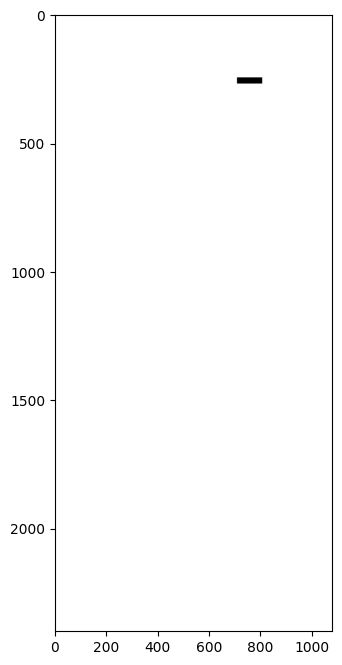

In [78]:
item = random.choice(data)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(item.draw())
plt.show()

In [82]:
item.validate_point(Position(x=600,y=500))

False